## Importing dependencies and dataset

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from Utils import AudioUtil, compile_and_train

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv2D, SeparableConv2D,  Conv1D, ZeroPadding2D, Dense, Flatten, Layer, LayerNormalization, BatchNormalization , Flatten
from tensorflow.keras.layers import ReLU,ELU,  LeakyReLU, MaxPool2D, MaxPool1D, add, Dropout, SpatialDropout2D, LSTM, Bidirectional, concatenate, Activation, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
main_dir=os.getcwd()
train_dir=main_dir+'\\train'
print('{}\n{}'.format(main_dir,train_dir))

train_df = pd.read_csv(main_dir+'\\2022challengeA_train.csv', index_col=0)

display(train_df[train_df.isna().any(axis=1)])
train_df = train_df.dropna()
train_df = train_df.drop([168], axis = 0)
train_df.index=range(len(train_df))

n_samples = len(train_df)

print('Number of rows: {}'.format(train_df.shape[0]))
display(train_df.sample(10))

au = AudioUtil()

c:\Users\david\Desktop\LOOP_Q_PRIZE
c:\Users\david\Desktop\LOOP_Q_PRIZE\train


,file_id,emotion,origin
8937,b78b41bd-3c6f-4182-94ac-430bad71f4e0.wav,NaN,tess


Number of rows: 10109


,file_id,emotion,origin
9783,40623b56-3a55-4014-8ed4-643cb626c5d2.wav,disgust,tess
5602,2519e0c9-1fe7-4414-8755-37789d8e5840.wav,fear,crema
4469,7df0576b-c763-43c6-b307-d019f6e5b1d6.wav,angry,crema
7326,7d8a819d-85db-440a-976f-ef6e6d18cd12.wav,happy,ravdess
9068,d9728b79-ab99-4f3b-ba03-340caa518ae6.wav,sadness,tess
2405,14361163-1c26-46c0-88d4-c24f5f11c46f.wav,disgust,crema
740,19678e10-9a8c-470c-8083-c744eb22e2a9.wav,neutral,crema
7978,67d5b20d-5304-4afa-86eb-7ba599fc0604.wav,neutral,tess
6061,fe749d64-bf3a-4c8e-9757-4d155a9086b6.wav,happy,crema
2286,10d7878d-4ea8-4706-a2c8-7b139e7d07bb.wav,fear,crema


## Introduction

I have extracted five different features from the audio files:

- Melscale spectrogram;
- Mfcc;
- Tonnetz representation;
- Chroma gram;
- Spectral Contrast.

I have used a length of the fft window of 1024, which corespond to 0.064s, and a number of samples between successive frames of 512. 
In this way all the features have 126 time steps

I have built a model for each feature. All the models share the same architecture: two 1D convolution to reduce the time steps dimension followed by two Bidirectional LSTM layers. Each convolutional layer is followed by a BatchNormalization layer and the last LSTM layer is followed by a 1D MaxPooling to reduce the dimensions and then flattened.

On top I have stacked two Dense layers of 256 neurons each, followed by the classification layer. 

As activation function I have used swish for each convolutional and dense layer except from the last layer, whose activation function is softmax.

I have pretrained each model to make them understand how to extract the relevant informations for this particular task.

To ensemble the models I have proceeded as follows:
- I have removed the last layer from each model;
- I have stacked a Dense layer with 64 neurons to each model;
- I have summed the outputs;
- I have stacked the classification layer with 7 neurons and the softmax activation function on top of the ensemble model.

## extracting features

In [3]:
# setting the parameters

n_fft = 1024
n_mels = 64
hop_len = int(n_fft / 2)

In [4]:
# inizializing the arrays of the features

sg = np.zeros(shape = (n_samples*3, 126, 64))
mf = np.zeros(shape = (n_samples*3, 126, 20))
cg = np.zeros(shape = (n_samples*3, 126, 12))
tn = np.zeros(shape = (n_samples*3, 126, 6))
sc = np.zeros(shape = (n_samples*3, 126, 7))

In [5]:
print('Creating the dataset with the features ...')

for i in range(n_samples):
    audio_file = train_dir + '\\' + train_df.loc[i, 'file_id']
    aud = librosa.load(audio_file)
    aud = au.process_audio(aud)
    for j in range(3):

        # Data Augmentation
        if j in [1,2]:
            aud = au.noise(aud)
            aud = au.time_shift(aud)

        mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len)
        mfcc = librosa.feature.mfcc(S = mel_sg)
        chroma_gram = librosa.feature.chroma_cqt(y = aud[0], sr = aud[1], hop_length=hop_len)
        tonnetz = librosa.feature.tonnetz(chroma = chroma_gram)
        spectral_contrast = librosa.feature.spectral_contrast(y = aud[0], sr = aud[1], n_fft = n_fft, hop_length = hop_len)

        k = n_samples*j + i

        sg[k] = mel_sg.transpose()
        mf[k] = mfcc.transpose()
        cg[k] = chroma_gram.transpose()
        tn[k] = tonnetz.transpose()
        sc[k] = spectral_contrast.transpose() 

    if i%100==0:
        print (str(['=' for i in range(i//100)]+['>']+['.' for i in range(n_samples//100-i//100)]).replace(',','').replace(' ','').replace("'", ''), end='\r')
print()       

print('Done !!')

Creating the dataset with the features ...
[=====================================================================================================>]
Done !!


Creating the masks for the training and test set

In [6]:
n = np.arange(len(train_df))

mask_train, mask_test = train_test_split(n, test_size = 0.1, random_state = 10)

mask_train = np.concatenate([mask_train, mask_train + n_samples, mask_train + 2*n_samples])
mask_test = np.concatenate([mask_test, mask_test + n_samples, mask_test + 2*n_samples])

Creating the array of the labels one hot encoded

In [15]:
enc = OneHotEncoder()
y = enc.fit_transform(np.array(train_df['emotion']).reshape(-1,1)).toarray()
y = np.concatenate([y, y, y])

## Creating and training the base models

Defining two utility functions to respectively download the data and build the model.

In [8]:

def get_data(feature):
    X = feature
   
    X_train, X_test, y_train, y_test = X[mask_train], X[mask_test], y[mask_train], y[mask_test]

    print('Shape of the feature = ', X[0].shape)
    print('(n train, n val, n test) = ', (mask_train.shape[0], mask_test.shape[0]))

    return X_train, X_test, y_train, y_test

def get_lstm_model(input_shape):
    input = Input(shape = input_shape)

    x = Conv1D(32, 5, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(32, 5, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Bidirectional(LSTM(32, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = Bidirectional(LSTM(32, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)

    x = Dropout(0.4)(x)
    x = Dense(256, activation = 'swish')(x)
    x = Dense(256, activation = 'swish')(x)
    output = Dense(7, activation = 'softmax')(x)

    model = Model(input, output)
    return model 

Training a model for each feature.

In [19]:
name_index = 0
name_features = ['sg', 'mf', 'cg', 'tn', 'sc']
for feature in [sg, mf, cg, tn, sc]:
    name = name_features[name_index]
    name_index+=1
    print('\n\n-----------------'+name.upper()+'-----------------\n\n')

    X_train, X_test, y_train, y_test = get_data(feature)
    input_shape = X_train.shape[1:]

    model = get_lstm_model(input_shape)
    model.summary()

    model.compile(optimizer =  'adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    batch_size=32
    epochs = 100

    callbacks_list = [EarlyStopping(patience = 10, monitor = 'val_categorical_accuracy'),
                      ModelCheckpoint('models/lstm_'+name, monitor = 'val_categorical_accuracy', save_best_only = True)]

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, validation_data = [X_test, y_test], callbacks = callbacks_list)

    print('\n\n-----------------END-----------------\n\n')



-----------------SG-----------------


Shape of the feature =  (126, 64)
(n train, n val, n test) =  (27294, 3033)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 126, 64)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 32)           10272     
                                                                 
 batch_normalization_2 (Batc  (None, 126, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 126, 32)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 63, 32)           0         
 1D)                                                             
        

853/853 [==============================] - 74s 77ms/step - loss: 1.3042 - categorical_accuracy: 0.4805 - val_loss: 4.0041 - val_categorical_accuracy: 0.2493
Epoch 2/100
853/853 [==============================] - ETA: 0s - loss: 1.0992 - categorical_accuracy: 0.5697INFO:tensorflow:Assets written to: models\lstm_sg\assets


INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 63s 74ms/step - loss: 1.0992 - categorical_accuracy: 0.5697 - val_loss: 1.2142 - val_categorical_accuracy: 0.5308
Epoch 3/100
853/853 [==============================] - 51s 60ms/step - loss: 1.0237 - categorical_accuracy: 0.6024 - val_loss: 1.9340 - val_categorical_accuracy: 0.3670
Epoch 4/100
853/853 [==============================] - 52s 61ms/step - loss: 0.9655 - categorical_accuracy: 0.6262 - val_loss: 2.0803 - val_categorical_accuracy: 0.4286
Epoch 5/100
853/853 [==============================] - 51s 60ms/step - loss: 0.9115 - categorical_accuracy: 0.6494 - val_loss: 1.5441 - val_categorical_accuracy: 0.5058
Epoch 6/100
853/853 [==============================] - ETA: 0s - loss: 0.8767 - categorical_accuracy: 0.6610INFO:tensorflow:Assets written to: models\lstm_sg\assets


INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 65s 76ms/step - loss: 0.8767 - categorical_accuracy: 0.6610 - val_loss: 1.0028 - val_categorical_accuracy: 0.6189
Epoch 7/100
853/853 [==============================] - ETA: 0s - loss: 0.8427 - categorical_accuracy: 0.6777INFO:tensorflow:Assets written to: models\lstm_sg\assets


INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 64s 75ms/step - loss: 0.8427 - categorical_accuracy: 0.6777 - val_loss: 1.0525 - val_categorical_accuracy: 0.6212
Epoch 8/100
853/853 [==============================] - ETA: 0s - loss: 0.8116 - categorical_accuracy: 0.6859INFO:tensorflow:Assets written to: models\lstm_sg\assets


INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 69s 81ms/step - loss: 0.8116 - categorical_accuracy: 0.6859 - val_loss: 0.9550 - val_categorical_accuracy: 0.6426
Epoch 9/100
853/853 [==============================] - 54s 63ms/step - loss: 0.7869 - categorical_accuracy: 0.6962 - val_loss: 1.1017 - val_categorical_accuracy: 0.6017
Epoch 10/100
853/853 [==============================] - 53s 62ms/step - loss: 0.7558 - categorical_accuracy: 0.7096 - val_loss: 1.1676 - val_categorical_accuracy: 0.5714
Epoch 11/100
853/853 [==============================] - 53s 63ms/step - loss: 0.7300 - categorical_accuracy: 0.7201 - val_loss: 1.0046 - val_categorical_accuracy: 0.6340
Epoch 12/100
853/853 [==============================] - 55s 64ms/step - loss: 0.7070 - categorical_accuracy: 0.7287 - val_loss: 1.5905 - val_categorical_accuracy: 0.5585
Epoch 13/100
853/853 [==============================] - 55s 64ms/step - loss: 0.6805 - categorical_accuracy: 0.7369 - val_loss: 1.1999 - val_categorical_accuracy: 0

INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 66s 77ms/step - loss: 0.5764 - categorical_accuracy: 0.7765 - val_loss: 1.0143 - val_categorical_accuracy: 0.6469
Epoch 19/100
853/853 [==============================] - 53s 62ms/step - loss: 0.5536 - categorical_accuracy: 0.7875 - val_loss: 1.4884 - val_categorical_accuracy: 0.5951
Epoch 20/100
853/853 [==============================] - 54s 63ms/step - loss: 0.5377 - categorical_accuracy: 0.7941 - val_loss: 1.1681 - val_categorical_accuracy: 0.6241
Epoch 21/100
853/853 [==============================] - 54s 64ms/step - loss: 0.5197 - categorical_accuracy: 0.8002 - val_loss: 1.2689 - val_categorical_accuracy: 0.6264
Epoch 22/100
853/853 [==============================] - ETA: 0s - loss: 0.5061 - categorical_accuracy: 0.8070INFO:tensorflow:Assets written to: models\lstm_sg\assets


INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 67s 79ms/step - loss: 0.5061 - categorical_accuracy: 0.8070 - val_loss: 1.0964 - val_categorical_accuracy: 0.6680
Epoch 23/100
853/853 [==============================] - 55s 65ms/step - loss: 0.4904 - categorical_accuracy: 0.8101 - val_loss: 1.7039 - val_categorical_accuracy: 0.5964
Epoch 24/100
853/853 [==============================] - 58s 68ms/step - loss: 0.4712 - categorical_accuracy: 0.8203 - val_loss: 1.6436 - val_categorical_accuracy: 0.6014
Epoch 25/100
853/853 [==============================] - 57s 66ms/step - loss: 0.4586 - categorical_accuracy: 0.8258 - val_loss: 1.2799 - val_categorical_accuracy: 0.6185
Epoch 26/100
853/853 [==============================] - 57s 67ms/step - loss: 0.4398 - categorical_accuracy: 0.8310 - val_loss: 1.2535 - val_categorical_accuracy: 0.6479
Epoch 27/100
853/853 [==============================] - ETA: 0s - loss: 0.4384 - categorical_accuracy: 0.8318INFO:tensorflow:Assets written to: models\lstm_sg\asse

INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 72s 84ms/step - loss: 0.4384 - categorical_accuracy: 0.8318 - val_loss: 1.1268 - val_categorical_accuracy: 0.6690
Epoch 28/100
853/853 [==============================] - 56s 66ms/step - loss: 0.4246 - categorical_accuracy: 0.8387 - val_loss: 1.3168 - val_categorical_accuracy: 0.6307
Epoch 29/100
853/853 [==============================] - 57s 66ms/step - loss: 0.4076 - categorical_accuracy: 0.8433 - val_loss: 1.1568 - val_categorical_accuracy: 0.6670
Epoch 30/100
853/853 [==============================] - 56s 65ms/step - loss: 0.3994 - categorical_accuracy: 0.8465 - val_loss: 1.2733 - val_categorical_accuracy: 0.6512
Epoch 31/100
853/853 [==============================] - 55s 64ms/step - loss: 0.3871 - categorical_accuracy: 0.8543 - val_loss: 1.3227 - val_categorical_accuracy: 0.6525
Epoch 32/100
853/853 [==============================] - ETA: 0s - loss: 0.3894 - categorical_accuracy: 0.8520INFO:tensorflow:Assets written to: models\lstm_sg\asse

INFO:tensorflow:Assets written to: models\lstm_sg\assets


853/853 [==============================] - 69s 81ms/step - loss: 0.3894 - categorical_accuracy: 0.8520 - val_loss: 1.1791 - val_categorical_accuracy: 0.6700
Epoch 33/100
853/853 [==============================] - 55s 64ms/step - loss: 0.3671 - categorical_accuracy: 0.8624 - val_loss: 1.2230 - val_categorical_accuracy: 0.6459
Epoch 34/100
853/853 [==============================] - 58s 68ms/step - loss: 0.3597 - categorical_accuracy: 0.8642 - val_loss: 1.5802 - val_categorical_accuracy: 0.6001
Epoch 35/100
853/853 [==============================] - 58s 68ms/step - loss: 0.3518 - categorical_accuracy: 0.8677 - val_loss: 1.6559 - val_categorical_accuracy: 0.6142
Epoch 36/100
853/853 [==============================] - 54s 63ms/step - loss: 0.3539 - categorical_accuracy: 0.8665 - val_loss: 1.4726 - val_categorical_accuracy: 0.6182
Epoch 37/100
853/853 [==============================] - 61s 71ms/step - loss: 0.3412 - categorical_accuracy: 0.8703 - val_loss: 1.5583 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 79s 82ms/step - loss: 1.2901 - categorical_accuracy: 0.4921 - val_loss: 1.2198 - val_categorical_accuracy: 0.5285
Epoch 2/100
853/853 [==============================] - ETA: 0s - loss: 1.0652 - categorical_accuracy: 0.5831INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 69s 81ms/step - loss: 1.0652 - categorical_accuracy: 0.5831 - val_loss: 1.0380 - val_categorical_accuracy: 0.5895
Epoch 3/100
853/853 [==============================] - 57s 66ms/step - loss: 0.9881 - categorical_accuracy: 0.6164 - val_loss: 1.0745 - val_categorical_accuracy: 0.5773
Epoch 4/100
853/853 [==============================] - ETA: 0s - loss: 0.9284 - categorical_accuracy: 0.6422INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 71s 84ms/step - loss: 0.9284 - categorical_accuracy: 0.6422 - val_loss: 0.9676 - val_categorical_accuracy: 0.6350
Epoch 5/100
853/853 [==============================] - 57s 66ms/step - loss: 0.8858 - categorical_accuracy: 0.6556 - val_loss: 0.9315 - val_categorical_accuracy: 0.6347
Epoch 6/100
853/853 [==============================] - 57s 66ms/step - loss: 0.8495 - categorical_accuracy: 0.6724 - val_loss: 1.1655 - val_categorical_accuracy: 0.5697
Epoch 7/100
853/853 [==============================] - 56s 66ms/step - loss: 0.8112 - categorical_accuracy: 0.6904 - val_loss: 1.0129 - val_categorical_accuracy: 0.6169
Epoch 8/100
853/853 [==============================] - ETA: 0s - loss: 0.7809 - categorical_accuracy: 0.7026INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 71s 83ms/step - loss: 0.7809 - categorical_accuracy: 0.7026 - val_loss: 1.0162 - val_categorical_accuracy: 0.6357
Epoch 9/100
853/853 [==============================] - 57s 66ms/step - loss: 0.7495 - categorical_accuracy: 0.7122 - val_loss: 1.2737 - val_categorical_accuracy: 0.5813
Epoch 10/100
853/853 [==============================] - ETA: 0s - loss: 0.7240 - categorical_accuracy: 0.7213INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 71s 83ms/step - loss: 0.7240 - categorical_accuracy: 0.7213 - val_loss: 0.9819 - val_categorical_accuracy: 0.6485
Epoch 11/100
853/853 [==============================] - ETA: 0s - loss: 0.7003 - categorical_accuracy: 0.7331INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 70s 82ms/step - loss: 0.7003 - categorical_accuracy: 0.7331 - val_loss: 0.9183 - val_categorical_accuracy: 0.6630
Epoch 12/100
853/853 [==============================] - ETA: 0s - loss: 0.6741 - categorical_accuracy: 0.7435INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 70s 82ms/step - loss: 0.6741 - categorical_accuracy: 0.7435 - val_loss: 0.9330 - val_categorical_accuracy: 0.6726
Epoch 13/100
853/853 [==============================] - 56s 65ms/step - loss: 0.6487 - categorical_accuracy: 0.7521 - val_loss: 1.0236 - val_categorical_accuracy: 0.6413
Epoch 14/100
853/853 [==============================] - ETA: 0s - loss: 0.6334 - categorical_accuracy: 0.7602INFO:tensorflow:Assets written to: models\lstm_mf\assets


INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 69s 81ms/step - loss: 0.6334 - categorical_accuracy: 0.7602 - val_loss: 0.9526 - val_categorical_accuracy: 0.6779
Epoch 15/100
853/853 [==============================] - 56s 66ms/step - loss: 0.6078 - categorical_accuracy: 0.7676 - val_loss: 1.0214 - val_categorical_accuracy: 0.6591
Epoch 16/100
853/853 [==============================] - 57s 66ms/step - loss: 0.5801 - categorical_accuracy: 0.7780 - val_loss: 1.0057 - val_categorical_accuracy: 0.6673
Epoch 17/100
853/853 [==============================] - 57s 67ms/step - loss: 0.5658 - categorical_accuracy: 0.7820 - val_loss: 1.0820 - val_categorical_accuracy: 0.6495
Epoch 18/100
853/853 [==============================] - 57s 67ms/step - loss: 0.5425 - categorical_accuracy: 0.7907 - val_loss: 1.0456 - val_categorical_accuracy: 0.6617
Epoch 19/100
853/853 [==============================] - 57s 66ms/step - loss: 0.5234 - categorical_accuracy: 0.7994 - val_loss: 1.0820 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 73s 85ms/step - loss: 0.4812 - categorical_accuracy: 0.8165 - val_loss: 1.0614 - val_categorical_accuracy: 0.6785
Epoch 23/100
853/853 [==============================] - 62s 73ms/step - loss: 0.4598 - categorical_accuracy: 0.8246 - val_loss: 1.1755 - val_categorical_accuracy: 0.6673
Epoch 24/100
853/853 [==============================] - 63s 74ms/step - loss: 0.4487 - categorical_accuracy: 0.8282 - val_loss: 1.1122 - val_categorical_accuracy: 0.6677
Epoch 25/100
853/853 [==============================] - 63s 74ms/step - loss: 0.4275 - categorical_accuracy: 0.8370 - val_loss: 1.3233 - val_categorical_accuracy: 0.6538
Epoch 26/100
853/853 [==============================] - 63s 74ms/step - loss: 0.4183 - categorical_accuracy: 0.8427 - val_loss: 1.1221 - val_categorical_accuracy: 0.6733
Epoch 27/100
853/853 [==============================] - 63s 74ms/step - loss: 0.4077 - categorical_accuracy: 0.8456 - val_loss: 1.3109 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 78s 91ms/step - loss: 0.3909 - categorical_accuracy: 0.8519 - val_loss: 1.1876 - val_categorical_accuracy: 0.6828
Epoch 30/100
853/853 [==============================] - 62s 73ms/step - loss: 0.3704 - categorical_accuracy: 0.8584 - val_loss: 1.3183 - val_categorical_accuracy: 0.6525
Epoch 31/100
853/853 [==============================] - 62s 73ms/step - loss: 0.3601 - categorical_accuracy: 0.8659 - val_loss: 1.2076 - val_categorical_accuracy: 0.6719
Epoch 32/100
853/853 [==============================] - 63s 73ms/step - loss: 0.3606 - categorical_accuracy: 0.8654 - val_loss: 1.1564 - val_categorical_accuracy: 0.6789
Epoch 33/100
853/853 [==============================] - 63s 74ms/step - loss: 0.3374 - categorical_accuracy: 0.8726 - val_loss: 1.3351 - val_categorical_accuracy: 0.6482
Epoch 34/100
853/853 [==============================] - 64s 75ms/step - loss: 0.3385 - categorical_accuracy: 0.8733 - val_loss: 1.4203 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 77s 90ms/step - loss: 0.2945 - categorical_accuracy: 0.8895 - val_loss: 1.3117 - val_categorical_accuracy: 0.6835
Epoch 40/100
853/853 [==============================] - 63s 74ms/step - loss: 0.2971 - categorical_accuracy: 0.8904 - val_loss: 1.4081 - val_categorical_accuracy: 0.6673
Epoch 41/100
853/853 [==============================] - 63s 74ms/step - loss: 0.2897 - categorical_accuracy: 0.8934 - val_loss: 1.4881 - val_categorical_accuracy: 0.6591
Epoch 42/100
853/853 [==============================] - 63s 74ms/step - loss: 0.2841 - categorical_accuracy: 0.8959 - val_loss: 1.3624 - val_categorical_accuracy: 0.6713
Epoch 43/100
853/853 [==============================] - 63s 74ms/step - loss: 0.2708 - categorical_accuracy: 0.8995 - val_loss: 1.3293 - val_categorical_accuracy: 0.6795
Epoch 44/100
853/853 [==============================] - 63s 74ms/step - loss: 0.2727 - categorical_accuracy: 0.8987 - val_loss: 1.4944 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_mf\assets


853/853 [==============================] - 76s 89ms/step - loss: 0.2652 - categorical_accuracy: 0.9016 - val_loss: 1.3787 - val_categorical_accuracy: 0.6861
Epoch 46/100
853/853 [==============================] - 60s 70ms/step - loss: 0.2558 - categorical_accuracy: 0.9066 - val_loss: 1.4109 - val_categorical_accuracy: 0.6756
Epoch 47/100
853/853 [==============================] - 61s 72ms/step - loss: 0.2511 - categorical_accuracy: 0.9069 - val_loss: 1.5212 - val_categorical_accuracy: 0.6690
Epoch 48/100
853/853 [==============================] - 61s 72ms/step - loss: 0.2443 - categorical_accuracy: 0.9102 - val_loss: 1.6023 - val_categorical_accuracy: 0.6782
Epoch 49/100
853/853 [==============================] - 62s 73ms/step - loss: 0.2482 - categorical_accuracy: 0.9094 - val_loss: 1.5675 - val_categorical_accuracy: 0.6630
Epoch 50/100
853/853 [==============================] - 61s 72ms/step - loss: 0.2434 - categorical_accuracy: 0.9092 - val_loss: 1.4519 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 92s 97ms/step - loss: 1.3719 - categorical_accuracy: 0.4428 - val_loss: 1.2578 - val_categorical_accuracy: 0.4807
Epoch 2/100
853/853 [==============================] - ETA: 0s - loss: 1.1994 - categorical_accuracy: 0.5199INFO:tensorflow:Assets written to: models\lstm_cg\assets


INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 82s 96ms/step - loss: 1.1994 - categorical_accuracy: 0.5199 - val_loss: 1.3015 - val_categorical_accuracy: 0.4903
Epoch 3/100
853/853 [==============================] - ETA: 0s - loss: 1.1327 - categorical_accuracy: 0.5487INFO:tensorflow:Assets written to: models\lstm_cg\assets


INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 82s 96ms/step - loss: 1.1327 - categorical_accuracy: 0.5487 - val_loss: 1.2572 - val_categorical_accuracy: 0.4916
Epoch 4/100
853/853 [==============================] - 69s 80ms/step - loss: 1.0828 - categorical_accuracy: 0.5698 - val_loss: 1.4712 - val_categorical_accuracy: 0.4761
Epoch 5/100
853/853 [==============================] - ETA: 0s - loss: 1.0435 - categorical_accuracy: 0.5862INFO:tensorflow:Assets written to: models\lstm_cg\assets


INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 82s 97ms/step - loss: 1.0435 - categorical_accuracy: 0.5862 - val_loss: 1.1657 - val_categorical_accuracy: 0.5463
Epoch 6/100
853/853 [==============================] - 64s 75ms/step - loss: 1.0044 - categorical_accuracy: 0.5999 - val_loss: 1.2286 - val_categorical_accuracy: 0.5394
Epoch 7/100
853/853 [==============================] - 66s 77ms/step - loss: 0.9835 - categorical_accuracy: 0.6130 - val_loss: 1.3919 - val_categorical_accuracy: 0.5091
Epoch 8/100
853/853 [==============================] - ETA: 0s - loss: 0.9495 - categorical_accuracy: 0.6274INFO:tensorflow:Assets written to: models\lstm_cg\assets


INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 80s 93ms/step - loss: 0.9495 - categorical_accuracy: 0.6274 - val_loss: 1.2575 - val_categorical_accuracy: 0.5473
Epoch 9/100
853/853 [==============================] - 67s 78ms/step - loss: 0.9201 - categorical_accuracy: 0.6414 - val_loss: 1.8712 - val_categorical_accuracy: 0.4685
Epoch 10/100
853/853 [==============================] - ETA: 0s - loss: 0.8903 - categorical_accuracy: 0.6517INFO:tensorflow:Assets written to: models\lstm_cg\assets


INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 81s 96ms/step - loss: 0.8903 - categorical_accuracy: 0.6517 - val_loss: 1.1098 - val_categorical_accuracy: 0.5806
Epoch 11/100
853/853 [==============================] - 67s 78ms/step - loss: 0.8723 - categorical_accuracy: 0.6577 - val_loss: 1.3030 - val_categorical_accuracy: 0.5305
Epoch 12/100
853/853 [==============================] - 67s 79ms/step - loss: 0.8349 - categorical_accuracy: 0.6747 - val_loss: 1.2365 - val_categorical_accuracy: 0.5582
Epoch 13/100
853/853 [==============================] - 69s 81ms/step - loss: 0.8152 - categorical_accuracy: 0.6844 - val_loss: 1.2579 - val_categorical_accuracy: 0.5450
Epoch 14/100
853/853 [==============================] - 67s 79ms/step - loss: 0.7891 - categorical_accuracy: 0.6925 - val_loss: 1.5660 - val_categorical_accuracy: 0.5275
Epoch 15/100
853/853 [==============================] - 67s 79ms/step - loss: 0.7689 - categorical_accuracy: 0.6986 - val_loss: 1.3388 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_cg\assets


853/853 [==============================] - 80s 94ms/step - loss: 0.6792 - categorical_accuracy: 0.7343 - val_loss: 1.3080 - val_categorical_accuracy: 0.5816
Epoch 20/100
853/853 [==============================] - 66s 77ms/step - loss: 0.6619 - categorical_accuracy: 0.7462 - val_loss: 1.3836 - val_categorical_accuracy: 0.5796
Epoch 21/100
853/853 [==============================] - 65s 76ms/step - loss: 0.6426 - categorical_accuracy: 0.7508 - val_loss: 1.6700 - val_categorical_accuracy: 0.5120
Epoch 22/100
853/853 [==============================] - 65s 76ms/step - loss: 0.6192 - categorical_accuracy: 0.7615 - val_loss: 1.4825 - val_categorical_accuracy: 0.5500
Epoch 23/100
853/853 [==============================] - 65s 76ms/step - loss: 0.6153 - categorical_accuracy: 0.7631 - val_loss: 1.6214 - val_categorical_accuracy: 0.5414
Epoch 24/100
853/853 [==============================] - 65s 76ms/step - loss: 0.5932 - categorical_accuracy: 0.7714 - val_loss: 1.3966 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 86s 92ms/step - loss: 1.5054 - categorical_accuracy: 0.3738 - val_loss: 1.3955 - val_categorical_accuracy: 0.4181
Epoch 2/100
853/853 [==============================] - ETA: 0s - loss: 1.3197 - categorical_accuracy: 0.4642INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 78s 91ms/step - loss: 1.3197 - categorical_accuracy: 0.4642 - val_loss: 1.3834 - val_categorical_accuracy: 0.4247
Epoch 3/100
853/853 [==============================] - ETA: 0s - loss: 1.2537 - categorical_accuracy: 0.4916INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 77s 90ms/step - loss: 1.2537 - categorical_accuracy: 0.4916 - val_loss: 1.3654 - val_categorical_accuracy: 0.4741
Epoch 4/100
853/853 [==============================] - 65s 76ms/step - loss: 1.2060 - categorical_accuracy: 0.5154 - val_loss: 1.3622 - val_categorical_accuracy: 0.4540
Epoch 5/100
853/853 [==============================] - ETA: 0s - loss: 1.1684 - categorical_accuracy: 0.5277INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 79s 93ms/step - loss: 1.1684 - categorical_accuracy: 0.5277 - val_loss: 1.3009 - val_categorical_accuracy: 0.4955
Epoch 6/100
853/853 [==============================] - 64s 75ms/step - loss: 1.1411 - categorical_accuracy: 0.5402 - val_loss: 1.4574 - val_categorical_accuracy: 0.4540
Epoch 7/100
853/853 [==============================] - 65s 77ms/step - loss: 1.1117 - categorical_accuracy: 0.5553 - val_loss: 1.3773 - val_categorical_accuracy: 0.4761
Epoch 8/100
853/853 [==============================] - 65s 76ms/step - loss: 1.0838 - categorical_accuracy: 0.5676 - val_loss: 1.3385 - val_categorical_accuracy: 0.4771
Epoch 9/100
853/853 [==============================] - ETA: 0s - loss: 1.0582 - categorical_accuracy: 0.5773INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 79s 93ms/step - loss: 1.0582 - categorical_accuracy: 0.5773 - val_loss: 1.2376 - val_categorical_accuracy: 0.5223
Epoch 10/100
853/853 [==============================] - 64s 75ms/step - loss: 1.0418 - categorical_accuracy: 0.5843 - val_loss: 1.3387 - val_categorical_accuracy: 0.4929
Epoch 11/100
853/853 [==============================] - ETA: 0s - loss: 1.0200 - categorical_accuracy: 0.5960INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 78s 92ms/step - loss: 1.0200 - categorical_accuracy: 0.5960 - val_loss: 1.2028 - val_categorical_accuracy: 0.5318
Epoch 12/100
853/853 [==============================] - ETA: 0s - loss: 0.9989 - categorical_accuracy: 0.6011INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 77s 90ms/step - loss: 0.9989 - categorical_accuracy: 0.6011 - val_loss: 1.1715 - val_categorical_accuracy: 0.5460
Epoch 13/100
853/853 [==============================] - 62s 73ms/step - loss: 0.9724 - categorical_accuracy: 0.6137 - val_loss: 1.2972 - val_categorical_accuracy: 0.5328
Epoch 14/100
853/853 [==============================] - ETA: 0s - loss: 0.9508 - categorical_accuracy: 0.6223INFO:tensorflow:Assets written to: models\lstm_tn\assets


INFO:tensorflow:Assets written to: models\lstm_tn\assets


853/853 [==============================] - 78s 91ms/step - loss: 0.9508 - categorical_accuracy: 0.6223 - val_loss: 1.2092 - val_categorical_accuracy: 0.5582
Epoch 15/100
853/853 [==============================] - 63s 74ms/step - loss: 0.9284 - categorical_accuracy: 0.6308 - val_loss: 1.3650 - val_categorical_accuracy: 0.5137
Epoch 16/100
853/853 [==============================] - 64s 75ms/step - loss: 0.9131 - categorical_accuracy: 0.6401 - val_loss: 1.2768 - val_categorical_accuracy: 0.5285
Epoch 17/100
853/853 [==============================] - 65s 76ms/step - loss: 0.8814 - categorical_accuracy: 0.6512 - val_loss: 1.3723 - val_categorical_accuracy: 0.5160
Epoch 18/100
853/853 [==============================] - 64s 75ms/step - loss: 0.8677 - categorical_accuracy: 0.6562 - val_loss: 1.3216 - val_categorical_accuracy: 0.5249
Epoch 19/100
853/853 [==============================] - 64s 75ms/step - loss: 0.8459 - categorical_accuracy: 0.6666 - val_loss: 1.2859 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 84s 90ms/step - loss: 1.5667 - categorical_accuracy: 0.3602 - val_loss: 1.5191 - val_categorical_accuracy: 0.3475
Epoch 2/100
853/853 [==============================] - ETA: 0s - loss: 1.3255 - categorical_accuracy: 0.4639INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 75s 88ms/step - loss: 1.3255 - categorical_accuracy: 0.4639 - val_loss: 1.4673 - val_categorical_accuracy: 0.4306
Epoch 3/100
853/853 [==============================] - ETA: 0s - loss: 1.2433 - categorical_accuracy: 0.5003INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 74s 87ms/step - loss: 1.2433 - categorical_accuracy: 0.5003 - val_loss: 1.2894 - val_categorical_accuracy: 0.4807
Epoch 4/100
853/853 [==============================] - ETA: 0s - loss: 1.1946 - categorical_accuracy: 0.5195INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 75s 88ms/step - loss: 1.1946 - categorical_accuracy: 0.5195 - val_loss: 1.2241 - val_categorical_accuracy: 0.5140
Epoch 5/100
853/853 [==============================] - 71s 83ms/step - loss: 1.1582 - categorical_accuracy: 0.5363 - val_loss: 1.2144 - val_categorical_accuracy: 0.5110
Epoch 6/100
853/853 [==============================] - ETA: 0s - loss: 1.1306 - categorical_accuracy: 0.5476INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 86s 100ms/step - loss: 1.1306 - categorical_accuracy: 0.5476 - val_loss: 1.2102 - val_categorical_accuracy: 0.5193
Epoch 7/100
853/853 [==============================] - ETA: 0s - loss: 1.1070 - categorical_accuracy: 0.5576INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 84s 99ms/step - loss: 1.1070 - categorical_accuracy: 0.5576 - val_loss: 1.2045 - val_categorical_accuracy: 0.5348
Epoch 8/100
853/853 [==============================] - ETA: 0s - loss: 1.0779 - categorical_accuracy: 0.5696INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 83s 98ms/step - loss: 1.0779 - categorical_accuracy: 0.5696 - val_loss: 1.1555 - val_categorical_accuracy: 0.5397
Epoch 9/100
853/853 [==============================] - 69s 81ms/step - loss: 1.0627 - categorical_accuracy: 0.5788 - val_loss: 1.2233 - val_categorical_accuracy: 0.5028
Epoch 10/100
853/853 [==============================] - 69s 81ms/step - loss: 1.0435 - categorical_accuracy: 0.5898 - val_loss: 1.3170 - val_categorical_accuracy: 0.5097
Epoch 11/100
853/853 [==============================] - ETA: 0s - loss: 1.0191 - categorical_accuracy: 0.5942INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 84s 99ms/step - loss: 1.0191 - categorical_accuracy: 0.5942 - val_loss: 1.2209 - val_categorical_accuracy: 0.5480
Epoch 12/100
853/853 [==============================] - ETA: 0s - loss: 0.9980 - categorical_accuracy: 0.6050INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 82s 97ms/step - loss: 0.9980 - categorical_accuracy: 0.6050 - val_loss: 1.1920 - val_categorical_accuracy: 0.5496
Epoch 13/100
853/853 [==============================] - 68s 79ms/step - loss: 0.9927 - categorical_accuracy: 0.6056 - val_loss: 1.2056 - val_categorical_accuracy: 0.5470
Epoch 14/100
853/853 [==============================] - ETA: 0s - loss: 0.9739 - categorical_accuracy: 0.6146INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 83s 97ms/step - loss: 0.9739 - categorical_accuracy: 0.6146 - val_loss: 1.1194 - val_categorical_accuracy: 0.5579
Epoch 15/100
853/853 [==============================] - 69s 80ms/step - loss: 0.9538 - categorical_accuracy: 0.6248 - val_loss: 1.2051 - val_categorical_accuracy: 0.5440
Epoch 16/100
853/853 [==============================] - 69s 80ms/step - loss: 0.9335 - categorical_accuracy: 0.6345 - val_loss: 1.1942 - val_categorical_accuracy: 0.5424
Epoch 17/100
853/853 [==============================] - 72s 85ms/step - loss: 0.9237 - categorical_accuracy: 0.6355 - val_loss: 1.2056 - val_categorical_accuracy: 0.5434
Epoch 18/100
853/853 [==============================] - 71s 83ms/step - loss: 0.9083 - categorical_accuracy: 0.6455 - val_loss: 1.7865 - val_categorical_accuracy: 0.4520
Epoch 19/100
853/853 [==============================] - 69s 81ms/step - loss: 0.8872 - categorical_accuracy: 0.6511 - val_loss: 1.4356 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 81s 96ms/step - loss: 0.8713 - categorical_accuracy: 0.6576 - val_loss: 1.2093 - val_categorical_accuracy: 0.5651
Epoch 21/100
853/853 [==============================] - 65s 77ms/step - loss: 0.8548 - categorical_accuracy: 0.6625 - val_loss: 1.2320 - val_categorical_accuracy: 0.5579
Epoch 22/100
853/853 [==============================] - ETA: 0s - loss: 0.8391 - categorical_accuracy: 0.6690INFO:tensorflow:Assets written to: models\lstm_sc\assets


INFO:tensorflow:Assets written to: models\lstm_sc\assets


853/853 [==============================] - 81s 94ms/step - loss: 0.8391 - categorical_accuracy: 0.6690 - val_loss: 1.2241 - val_categorical_accuracy: 0.5694
Epoch 23/100
853/853 [==============================] - 66s 77ms/step - loss: 0.8236 - categorical_accuracy: 0.6765 - val_loss: 1.2529 - val_categorical_accuracy: 0.5470
Epoch 24/100
853/853 [==============================] - 67s 79ms/step - loss: 0.8053 - categorical_accuracy: 0.6830 - val_loss: 1.2644 - val_categorical_accuracy: 0.5513
Epoch 25/100
853/853 [==============================] - 66s 78ms/step - loss: 0.8002 - categorical_accuracy: 0.6882 - val_loss: 1.2861 - val_categorical_accuracy: 0.5519
Epoch 26/100
853/853 [==============================] - 67s 78ms/step - loss: 0.7751 - categorical_accuracy: 0.6949 - val_loss: 1.4375 - val_categorical_accuracy: 0.5523
Epoch 27/100
853/853 [==============================] - 67s 78ms/step - loss: 0.7655 - categorical_accuracy: 0.7007 - val_loss: 1.3042 - val_categorical_accuracy: 

## Creating and Training the ensemble multi input model

Importing the LSTM models for each feature

In [28]:
sg_model = tf.keras.models.load_model('models/lstm_sg')
sg_model = Sequential(sg_model.layers[:-1])

mf_model = tf.keras.models.load_model('models/lstm_mf')
mf_model = Sequential(mf_model.layers[:-1])

cg_model = tf.keras.models.load_model('models/lstm_cg')
cg_model = Sequential(cg_model.layers[:-1])

tn_model = tf.keras.models.load_model('models/lstm_tn')
tn_model = Sequential(tn_model.layers[:-1])

sc_model = tf.keras.models.load_model('models/lstm_sc')
sc_model = Sequential(sc_model.layers[:-1])


sg_model._name = 'sg_model'
mf_model._name = 'mf_model'
cg_model._name = 'cg_model'
tn_model._name = 'tn_model'
sc_model._name = 'sc_model'

In [29]:
sg_model.summary()

Model: "sg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 32)           10272     
                                                                 
 batch_normalization_2 (Batc  (None, 126, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 126, 32)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 63, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 63, 32)            5152      
                                                                 
 batch_normalization_3 (Batc  (None, 63, 32)           128

Importing the features

In [30]:
sg_train, sg_test = sg[mask_train], sg[mask_test]
mf_train, mf_test = mf[mask_train], mf[mask_test]
cg_train, cg_test = cg[mask_train], cg[mask_test]
tn_train, tn_test = tn[mask_train], tn[mask_test]
sc_train, sc_test = sc[mask_train], sc[mask_test]

sg_shape = sg[0].shape
mf_shape = mf[0].shape
cg_shape = cg[0].shape
tn_shape = tn[0].shape
sc_shape = sc[0].shape

print('(n train, n val, n test) = ', (mask_train.shape[0], mask_test.shape[0]))

(n train, n val, n test) =  (27294, 3033)


Ensembling the models.

In [31]:
sg_input = Input(shape = sg_shape)
mf_input = Input(shape = mf_shape)
cg_input = Input(shape = cg_shape)
tn_input = Input(shape = tn_shape)
sc_input = Input(shape = sc_shape)

sg_output = sg_model(sg_input)
sg_output = Dense(64, activation = 'swish')(sg_output)

mf_output = mf_model(mf_input)
mf_output = Dense(64, activation = 'swish')(mf_output)

cg_output = cg_model(cg_input)
cg_output = Dense(64, activation = 'swish')(cg_output)

tn_output = tn_model(tn_input)
tn_output = Dense(64, activation = 'swish')(tn_output)

sc_output = sc_model(sc_input)
sc_output = Dense(64, activation = 'swish')(sc_output)

x = add([sg_output, mf_output, cg_output, tn_output, sc_output])

output = Dense(7, activation = 'softmax')(x)

model = Model([sg_input, mf_input, cg_input, tn_input, sc_input], output)

# freezing the base models' weights
for l in model.layers[:-7]:
    l.trainable = False

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 126, 64)]    0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 126, 20)]    0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 126, 12)]    0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 126, 6)]     0           []                               
                                                                                            

Training the model

In [33]:
X_train = [sg_train, mf_train, cg_train, tn_train, sc_train]
X_test = [sg_test,mf_test,cg_test,tn_test,sc_test] 

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

batch_size=32
epochs = 100

callbacks_list = [EarlyStopping(patience = 10, monitor = 'val_categorical_accuracy'),
                    ModelCheckpoint('models/multi_input_model', monitor = 'val_categorical_accuracy', save_best_only = True)]

history = model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, validation_data = [X_test, y_test], callbacks = callbacks_list)

Epoch 1/100
853/853 [==============================] - ETA: 0s - loss: 0.2611 - categorical_accuracy: 0.9121INFO:tensorflow:Assets written to: models\multi_input_model\assets


INFO:tensorflow:Assets written to: models\multi_input_model\assets


853/853 [==============================] - 424s 354ms/step - loss: 0.2611 - categorical_accuracy: 0.9121 - val_loss: 1.1890 - val_categorical_accuracy: 0.7349
Epoch 2/100
853/853 [==============================] - 116s 136ms/step - loss: 0.1034 - categorical_accuracy: 0.9615 - val_loss: 1.4183 - val_categorical_accuracy: 0.7234
Epoch 3/100
853/853 [==============================] - 116s 136ms/step - loss: 0.0925 - categorical_accuracy: 0.9660 - val_loss: 1.5569 - val_categorical_accuracy: 0.7155
Epoch 4/100
853/853 [==============================] - 119s 139ms/step - loss: 0.0844 - categorical_accuracy: 0.9695 - val_loss: 1.5954 - val_categorical_accuracy: 0.7260
Epoch 5/100
853/853 [==============================] - 118s 138ms/step - loss: 0.0819 - categorical_accuracy: 0.9692 - val_loss: 1.5983 - val_categorical_accuracy: 0.7263
Epoch 6/100
853/853 [==============================] - 113s 132ms/step - loss: 0.0776 - categorical_accuracy: 0.9715 - val_loss: 1.6198 - val_categorical_acc

## Results

In [9]:
sg_test = sg[mask_test]
mf_test = mf[mask_test]
cg_test = cg[mask_test]
tn_test = tn[mask_test]
sc_test = sc[mask_test]

X_test = [sg_test, mf_test, cg_test, tn_test, sc_test]

### Results per origin

Splitting the features per origin

In [11]:
crema_mask = train_df['origin']=='crema'
crema_mask = np.array(crema_mask[crema_mask].index)
crema_mask = np.intersect1d(crema_mask, mask_test)
sg_crema = sg[crema_mask]
mf_crema = mf[crema_mask]
cg_crema = cg[crema_mask]
tn_crema = tn[crema_mask]
sc_crema = sc[crema_mask]

ravdess_mask = train_df['origin']=='ravdess'
ravdess_mask = np.array(ravdess_mask[ravdess_mask].index)
ravdess_mask = np.intersect1d(ravdess_mask, mask_test)
sg_ravdess = sg[ravdess_mask]
mf_ravdess = mf[ravdess_mask]
cg_ravdess = cg[ravdess_mask]
tn_ravdess = tn[ravdess_mask]
sc_ravdess = sc[ravdess_mask]

savee_mask = train_df['origin']=='savee'
savee_mask = np.array(savee_mask[savee_mask].index)
savee_mask = np.intersect1d(savee_mask, mask_test)
sg_savee = sg[savee_mask]
mf_savee = mf[savee_mask]
cg_savee = cg[savee_mask]
tn_savee = tn[savee_mask]
sc_savee = sc[savee_mask]

tess_mask = train_df['origin']=='tess'
tess_mask = np.array(tess_mask[tess_mask].index)
tess_mask = np.intersect1d(tess_mask, mask_test)
sg_tess = sg[tess_mask]
mf_tess = mf[tess_mask]
cg_tess = cg[tess_mask]
tn_tess = tn[tess_mask]
sc_tess = sc[tess_mask]


ems = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sadness','surprise'])
enc = OneHotEncoder()
enc.fit(ems.reshape(-1,1))

OneHotEncoder()

In [15]:
X_crema = [sg_crema, mf_crema, cg_crema, tn_crema, sc_crema]
X_ravdess = [sg_ravdess, mf_ravdess, cg_ravdess, tn_ravdess, sc_ravdess]
X_savee = [sg_savee, mf_savee, cg_savee, tn_savee, sc_savee]
X_tess = [sg_tess, mf_tess, cg_tess, tn_tess, sc_tess]

y_crema = y[crema_mask]
y_ravdess = y[ravdess_mask]
y_savee = y[savee_mask]
y_tess = y[tess_mask]

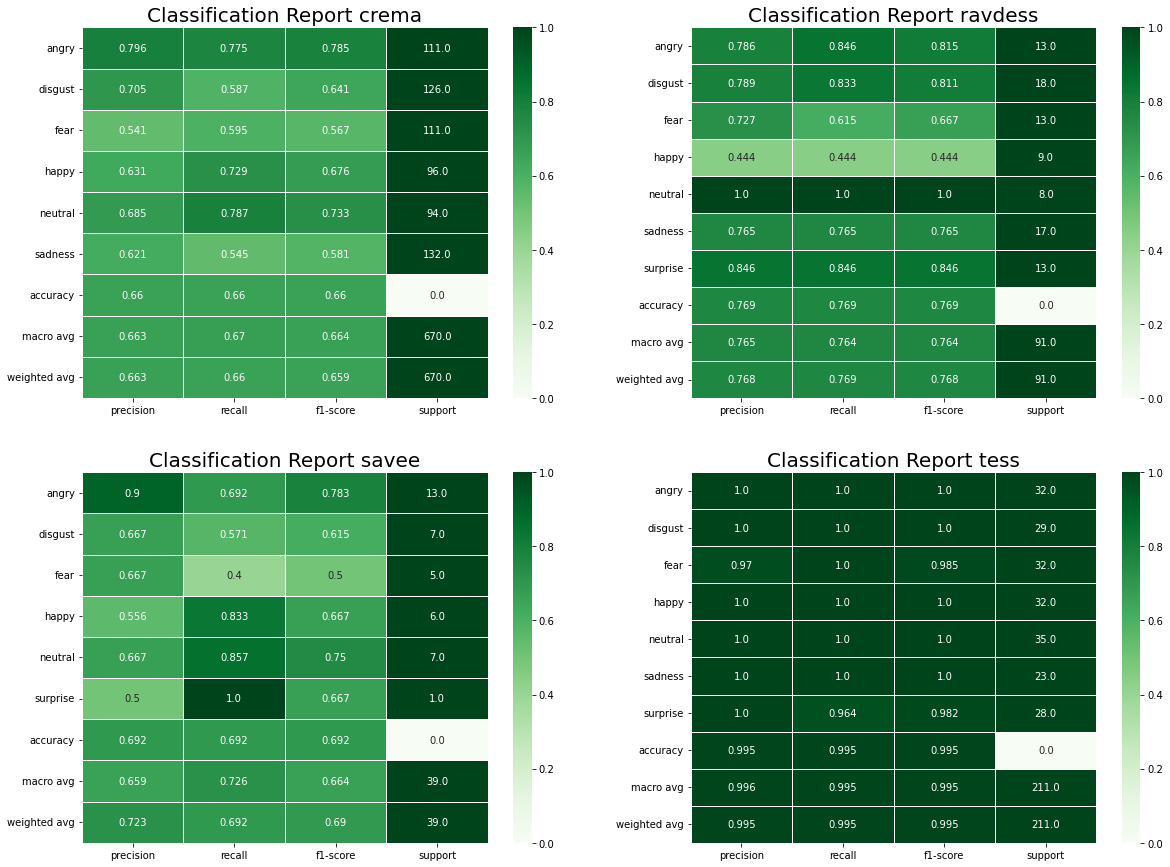

In [33]:
fig, axs = plt.subplots(2, 2, figsize = (20,15))
origins = ['crema', 'ravdess', 'savee', 'tess']
index = 0
for Xt, yt in list(zip([X_crema, X_ravdess, X_savee, X_tess], [y_crema, y_ravdess, y_savee, y_tess])):
    y_pred = model.predict(Xt)
    y_pred_label = enc.inverse_transform(y_pred)
    y_test_label = enc.inverse_transform(yt)
    cr = classification_report(y_test_label, y_pred_label, digits = 2, output_dict=True)
    if index ==0:
        i,j=0,0
    elif index == 1:
        i,j=0,1
    elif index == 2:
        i,j=1,0
    else:
        i,j=1,1

    cr = pd.DataFrame(cr).T
    cr.iloc[:,:3]=cr.iloc[:,:3].apply(lambda x: round(x, 3))
    cr.iloc[:,3]=cr.iloc[:,3].astype(int)
    sns.heatmap(cr, ax = axs[i,j], vmin=0, vmax=1, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
    axs[i,j].set_title('Classification Report '+origins[index], size = 20)

    index+=1


### Results on the merged dataset

Text(0.5, 1.0, 'Classification Report')

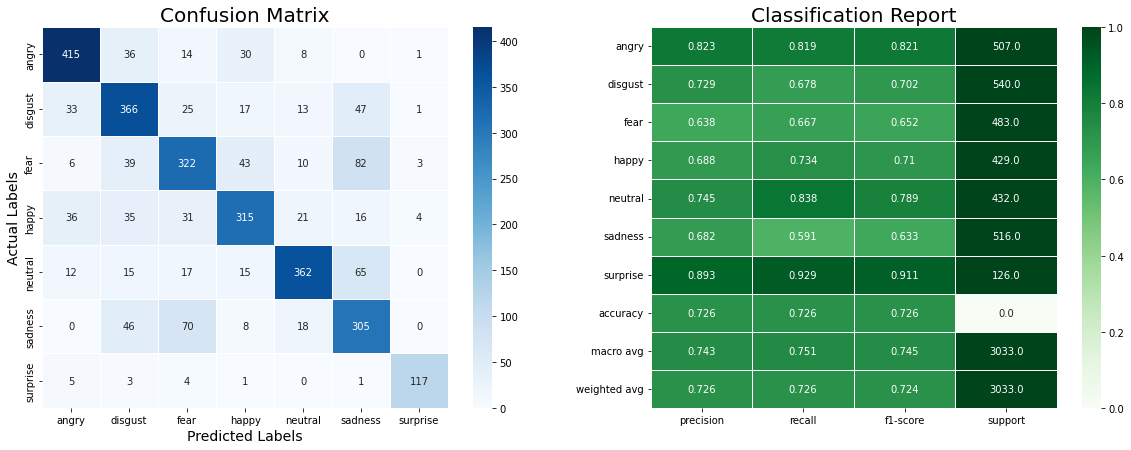

In [41]:
y_pred = model.predict(X_test)
y_pred_label = enc.inverse_transform(y_pred)
y_test_label = enc.inverse_transform(y_test)
fig, axs = plt.subplots(1, 2, figsize = (20,7))

# heat map of the confusion matrix

cm = confusion_matrix(y_pred_label, y_test_label)
cm = pd.DataFrame(cm , index = [i for i in ems] , columns = [i for i in ems])
sns.heatmap(cm,  ax = axs[0], linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
axs[0].set_title('Confusion Matrix', size=20)
axs[0].set_xlabel('Predicted Labels', size=14)
axs[0].set_ylabel('Actual Labels', size=14)

# heat map of the classification report

cr = classification_report(y_test_label, y_pred_label, digits = 2, output_dict = True)
cr = pd.DataFrame(cr).T
cr.iloc[:,:3]=cr.iloc[:,:3].apply(lambda x: round(x, 3))
cr.iloc[:,3]=cr.iloc[:,3].astype(int)
sns.heatmap(cr, ax = axs[1], vmin=0, vmax=1, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
axs[1].set_title('Classification Report', size = 20)